# Rapid-DSM - Google Earth Engine Change Detection

# Import Python Libraries

In [31]:
%load_ext autoreload
%autoreload 2
import os
import folium
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import json
from IPython.display import Image

import gee_helpers as geeh


import geopandas as gpd
from shapely.geometry import shape

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Authenticate Goolge Features

## Google Earth Engine Cli

In [ ]:
!earthengine authenticate

## Google Earth Engine for Python

In [ ]:
# Import the Earth Engine library.
import ee

# Trigger the authentication flow.
ee.Authenticate()
ee.Initialize()

# Default Configuration

## Goolge Cloud Storage

In [ ]:
## Google Drive Save Location
figures_save_location = "/output"

In [ ]:
from google.cloud import storage
storage_client = storage.Client(project=project_id)

## Get AOI for Wake County
Using open data portal api

## AOI: Walnut Creek Subwatershed

In [ ]:
# Data from Google Earth Engine 
# HUC12: USGS Watershed Boundary Dataset of Subwatersheds
subwatershed = ee.FeatureCollection("USGS/WBD/2017/HUC12")
aoi = (subwatershed.filter(
  ee.Filter.And(
    ee.Filter.eq("huc12", "030202011101"),
    ee.Filter.eq("states", "NC"),
    ee.Filter.eq("name", "Walnut Creek")
    )
  ))

url = aoi.getDownloadUrl(filetype="GEOJSON")
df_aoi = gpd.read_file(url)
# df_aoi.plot()
df_envelope = gpd.GeoDataFrame(geometry=gpd.GeoSeries(df_aoi['geometry'].envelope))
df_envelope.plot()
print(df_envelope.area)
aoi = df_envelope.to_file("aoi.json", driver='GeoJSON')
#make shapefile for GEE later
df_envelope.to_file("aoi")
with open("aoi.json", "r") as f:
  aoi_json = json.loads(f.read())
  print(aoi_json['features'][0]['geometry'])
  os.environ['AOI_STRING'] = AOI_STRING = str(aoi_json['features'][0]['geometry'])

# Change Detection

## Land Cover Land Change Value Mappings

In [ ]:
# Maps OSM key values to localized schema
land_covers = {
    'highway_residential': "road",
    'highway_motorway': "road",
    'highway_trunk': "road",
    'highway_primary': "road",
    'highway_secondary': "road",
    'highway_tertiary': "road",
    'highway_unclassified': "road",
    'highway_motorway_link': "road",
    'highway_trunk_link': "road",
    'highway_primary_link': "road",
    'highway_secondary_link': "road",
    'highway_tertiary_link': "road",
    'parking_surface': "developed",
    'surface_grass': "grass",
    'landuse_grass': "grass", 
    'landuse_meadow': "grass",
    "natural_grassland": "grass",
    'natural_water': "water",
    'natural_wood': "forest",
    'building_house': "building",
    'building_residential': "building",
    'building_retail': "building",
    'building_public': "building"
  }

query_keys = tuple(set([k.split('_')[0] for k in land_covers.keys()]))
query_values = tuple(set([k.split('_')[1] for k in land_covers.keys()]))
print(query_keys)
# Map of human readable landclasses to coded values
land_classes = {
    "road": 0, # Developed
    "building": 1, #Developed
    "barren": 2,
    "forest": 3,
    "grass": 4, #Herbaceous
    "water": 5,
    "developed": 6
  }

#colors from https://www.mrlc.gov/data/legends/national-land-cover-database-2011-nlcd2011-legend
landcover_color_palette = [
    'E29E8C', # Class 0 - road/highways         NLCD class color 22
    'B50000', # Class 1 - Building dark red     NLCD class color 24
    'D2CDC0', # Class 2 - barren                NLCD class color 31
    '38814E', # Class 3 - Forest                NLCD class color 42
    '85C77E', # Class 4 - Grass                 NLCD class color 41
    '5475A8', # Class 5 -  water                 NLCD class color 11
    'E8D1D1' # Class 5 -  developed             NLCD class color 21
]

## Priority Change Values

In [ ]:
change_priority = {
    "No Change": 0,
    "road to building": 7,
    "road to barren": 4,
    "road to water": 0,
    "road to grass": 1,
    "road to forest": 1,
    "road to developed": 4,
    "building to road": 1,
    "building to barren": 7,
    "building to water": 0,
    "building to grass": 3,
    "building to forest": 3,
    "building to developed": 5,
    "barren to road": 3,
    "barren to building": 7,
    "barren to water": 0,
    "barren to grass": 2,
    "barren to forest": 2,
    "barren to developed": 5,
    "water to road": 0,
    "water to building": 0,
    "water to barren": 0,
    "water to grass": 0,
    "water to forest": 0,
    "water to developed": 0,
    "grass to road": 3,
    "grass to building": 7,
    "grass to barren": 3,
    "grass to water":0,
    "grass to forest": 3,
    "grass to developed": 5,
    "forest to road": 3,
    "forest to building": 7,
    "forest to barren": 7,
    "forest to water": 0,
    "forest to grass": 3,
    "forest to developed": 7,
    "developed to road": 3,
    "developed to building": 7,
    "developed to barren": 7,
    "developed to water": 0,
    "developed to grass": 3,
    "developed to forest": 3
}

## Functions

In [ ]:
# Define a method for displaying Earth Engine image tiles to folium map.

# Add EE drawing method to folium.
folium.Map.add_ee_layer = geeh.add_ee_layer

result = geeh.generateFromToExpression(land_classes)
thematic_change_expression = result['expression']
tmp_change_class_data = [{"FromTo":v, "ClassID":result["labels"][v]} for v in result["labels"]]
df_change_classes = pd.DataFrame(tmp_change_class_data)
df_change_classes["priority"] = df_change_classes["FromTo"].map(change_priority)



In [ ]:
aoi_bbox = ee.FeatureCollection(gee_imagecollection_aoi)

subwatershed = ee.FeatureCollection("USGS/WBD/2017/HUC12")
aoi = (subwatershed.filter(
  ee.Filter.And(
    ee.Filter.eq("huc12", "030202011101"),
    ee.Filter.eq("states", "NC"),
    ee.Filter.eq("name", "Walnut Creek")
    )
  ))

coords = aoi.geometry().centroid().getInfo()['coordinates']
center_map = [coords[1], coords[0]]

## Download OpenStreetMap Data

In [ ]:
# Query Google Big Query to generate training data for image classification.

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
#old tag values removing roads to see if I can fix the max 
#AND tags.value in ("water", "grass","meadow","grassland", "forest", "residential","secondary","tertiary","unclassified", "primary", "motorway", "trunk","motorway_link","trunk_link","primary_link","secondary_link","tertiary_link", "quarry", "farmland", "sand", "ground", "dirt", "wood", "retail","public", "construction", "surface", "house") 

df_landcover_samples = pd.io.gbq.read_gbq('''
  SELECT feature_type,osm_timestamp, tags.key, tags.value, ST_ASGEOJSON(geometry) as geom
  FROM `bigquery-public-data.geo_openstreetmap.planet_features` AS feats,
  UNNEST(feats.all_tags) AS tags
  WHERE tags.key in ("building", "landuse", "highway", "water", "natural", "surface", "parking") 
      AND tags.value in ("water", "grass","meadow","grassland", "forest", "residential","secondary", "primary", "motorway", "trunk","trunk_link","primary_link","secondary_link","tertiary_link", "quarry", "farmland", "sand", "ground", "dirt", "wood", "retail","public", "construction", "surface", "house") 
      AND ST_INTERSECTS(feats.geometry, ST_GEOGFROMGEOJSON('{"type": "Polygon","coordinates": [[[ -78.782195642777026, 35.692691564447983 ],[ -78.531885144268472, 35.692691564447983 ],[ -78.531885144268472, 35.800084957942794 ],[ -78.782195642777026, 35.800084957942794 ],[ -78.782195642777026, 35.692691564447983 ]] ]}'))
  ''', project_id=project_id)

 #project_id is defined in config
# Create dataframe column that represents the OSM key value pair
df_landcover_samples["keyvalue"] = df_landcover_samples["key"] + "_" + df_landcover_samples["value"]

# Map land cover and land class values to matching OSM key value combinations and drop and rows that don't match.
df_landcover_samples["landcover"] = df_landcover_samples["keyvalue"].map(land_covers)
df_landcover_samples["landclass"] = df_landcover_samples["landcover"].map(land_classes)
df_landcover_samples = df_landcover_samples.dropna()
df_landcover_samples.isnull().sum()
df_null = df_landcover_samples[df_landcover_samples.isna().any(axis=1)]
df_landcover_samples.to_csv('gbq_landcover.csv')
assert df_null.size == 0, "DataFrame df_null should have a size of 0"


In [ ]:
df_landcover_samples.head()
df_landcover_samples.describe(include='all')

In [ ]:
sns.factorplot("landcover", data=df_landcover_samples, aspect=2, kind="count", color='steelblue')
plt.title('OpenStreetMap Feature Counts', fontsize=14) 
plt.tight_layout()
plt.savefig(os.path.join(figures_save_location,"osm_count" + "_by_type"),dpi=300)

## Export Data to CSV for Backup

In [ ]:
df_landcover_samples.to_csv('gbq_landcover.csv')

In [97]:
import geopandas as gpd
from shapely.geometry import shape

df_landcover_samples = gpd.read_file("data/gbq_landcover.csv")
df_landcover_samples['features'] = df_landcover_samples['geom'].apply(lambda x: {"geometry": json.loads(x) , "properties": {}, "type": "Feature"})
df_samples = df_landcover_samples[(df_landcover_samples['key'] != 'highway') & (df_landcover_samples['feature_type']!= 'lines')]

# base_geo = {
#   "type": "FeatureCollection",
#   "features": []
# }

# base_geo['features'] = df_samples['features'].tolist()

# for f in base_geo['features']:
#     try:
#         newShape = shape(f)
#     except:
#         print(f)
                  
# gdf = gpd.GeoDataFrame.from_features(base_geo['features'])
# with open("data/osm_samples.geojson", "w") as f:
#     dump = json.dumps(base_geo)
#     f.write(dump)


# close file
# f.close()
# gdf['features'] = gdf['geom'].apply(lambda x: {'geometry': shape(x) if x , 'properties': {}, 'type': 'Feature'})
df_samples['geometry'] = df_samples['geom'].apply(lambda x: shape(json.loads(x)) if x else None)
# df_samples['geom'] = df_samples['geom'].apply(shape)
# print(df_landcover_samples['geomerty'])
# gdf2 = gpd.read_file("data/osm_samples.geojson")
# gdf2.head()
# df_samples = gdf.set_geometry(df_samples.geometry)
# gdf2 = gpd.GeoDataFrame.from_features(gdf['features'])
# gdf = gdf.set_geometry(gdf2.geometry)
# gdf = gdf.set_geometry(gdf.geometry)
df_samples.head()


/home/coreywhite/.local/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
/home/coreywhite/.local/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,field_1,feature_type,osm_timestamp,key,value,geom,keyvalue,landcover,landclass,geometry,features
7,7,multipolygons,2015-11-11 16:29:17+00:00,natural,wood,"{ ""type"": ""Polygon"", ""coordinates"": [ [ [-78.6...",natural_wood,forest,3.0,"POLYGON ((-78.61906 35.78706, -78.61894 35.787...","{'geometry': {'type': 'Polygon', 'coordinates'..."
9,10,multipolygons,2015-11-09 18:15:21+00:00,building,residential,"{ ""type"": ""Polygon"", ""coordinates"": [ [ [-78.7...",building_residential,building,1.0,"POLYGON ((-78.78002 35.75507, -78.78009 35.755...","{'geometry': {'type': 'Polygon', 'coordinates'..."
11,12,multipolygons,2018-09-08 23:18:32+00:00,building,house,"{ ""type"": ""Polygon"", ""coordinates"": [ [ [-78.6...",building_house,building,1.0,"POLYGON ((-78.61826 35.73243, -78.61826 35.732...","{'geometry': {'type': 'Polygon', 'coordinates'..."
12,14,multipolygons,2016-04-24 15:09:55+00:00,natural,wood,"{ ""type"": ""Polygon"", ""coordinates"": [ [ [-78.6...",natural_wood,forest,3.0,"POLYGON ((-78.66802 35.77965, -78.66791 35.779...","{'geometry': {'type': 'Polygon', 'coordinates'..."
13,15,multipolygons,2018-08-03 20:28:35+00:00,building,house,"{ ""type"": ""Polygon"", ""coordinates"": [ [ [-78.6...",building_house,building,1.0,"POLYGON ((-78.66141 35.73474, -78.66137 35.734...","{'geometry': {'type': 'Polygon', 'coordinates'..."


<AxesSubplot:>

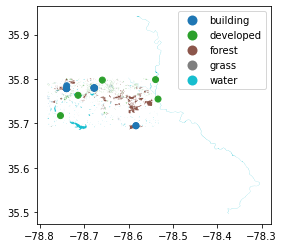

In [100]:
df_samples.plot("landcover", legend=True)

In [117]:
df_samples['landcover'].unique()
df_samples['landclass'] = pd.to_numeric(df_samples['landclass'], downcast="integer")
df_samples['landclass'].unique()


array([3, 1, 6, 4, 5], dtype=int8)

In [118]:
# df_samples['landclass'] = df_samples['landclass'].astype(int)
df_samples[['landcover','landclass','geometry']].set_crs('epsg:4326').to_file('data/osm_samples.gpkg', driver='GPKG', layer='osm_samples')  

In [53]:
df_landcover_samples['date'] = pd.to_datetime(df_landcover_samples.osm_timestamp,format='%Y%m', errors='coerce')
df_landcover_samples['month_year'] = pd.to_datetime(df_landcover_samples['date']).dt.to_period('M')
df_landcover_samples['count'] = 1
df_landcover_samples.head()

# df_osm_temporal = df_landcover_samples.groupby(by=["month_year",'landcover'], as_index=False).count()
# df_osm_temporal = df_osm_temporal.pivot( "month_year","landcover", "count")
# df_osm_temporal = df_osm_temporal.resample('1M').count().fillna(0)
# ax = df_osm_temporal.plot(kind='area')
# ax.set_xlabel("Year")
# ax.set_ylabel("Count")
# plt.savefig(os.path.join(figures_save_location,"osm_year_count" + "_by_type"),dpi=300)


,field_1,feature_type,osm_timestamp,key,value,geom,keyvalue,landcover,landclass,geometry,date,month_year,count
0,0,lines,2019-07-12 02:10:03+00:00,highway,residential,"{ ""type"": ""LineString"", ""coordinates"": [ [-78....",highway_residential,road,0.0,None,NaT,NaT,1
1,1,lines,2019-11-27 10:53:56+00:00,highway,residential,"{ ""type"": ""LineString"", ""coordinates"": [ [-78....",highway_residential,road,0.0,None,NaT,NaT,1
2,2,lines,2021-06-25 16:56:01+00:00,highway,residential,"{ ""type"": ""LineString"", ""coordinates"": [ [-78....",highway_residential,road,0.0,None,NaT,NaT,1
3,3,lines,2019-11-30 02:29:58+00:00,highway,residential,"{ ""type"": ""LineString"", ""coordinates"": [ [-78....",highway_residential,road,0.0,None,NaT,NaT,1
4,4,lines,2021-02-19 08:55:00+00:00,highway,residential,"{ ""type"": ""LineString"", ""coordinates"": [ [-78....",highway_residential,road,0.0,None,NaT,NaT,1


In [61]:
for index, row in df_landcover_samples.iterrows():
    geojson = json.loads(row["geom"])
    feature = shape(geojson)
    row["geometry"] = feature

df_landcover_samples.head()

,field_1,feature_type,osm_timestamp,key,value,geom,keyvalue,landcover,landclass,geometry,features
0,0,lines,2019-07-12 02:10:03+00:00,highway,residential,"{ ""type"": ""LineString"", ""coordinates"": [ [-78....",highway_residential,road,0.0,None,"{'geometry': '{ ""type"": ""LineString"", ""coordin..."
1,1,lines,2019-11-27 10:53:56+00:00,highway,residential,"{ ""type"": ""LineString"", ""coordinates"": [ [-78....",highway_residential,road,0.0,None,"{'geometry': '{ ""type"": ""LineString"", ""coordin..."
2,2,lines,2021-06-25 16:56:01+00:00,highway,residential,"{ ""type"": ""LineString"", ""coordinates"": [ [-78....",highway_residential,road,0.0,None,"{'geometry': '{ ""type"": ""LineString"", ""coordin..."
3,3,lines,2019-11-30 02:29:58+00:00,highway,residential,"{ ""type"": ""LineString"", ""coordinates"": [ [-78....",highway_residential,road,0.0,None,"{'geometry': '{ ""type"": ""LineString"", ""coordin..."
4,4,lines,2021-02-19 08:55:00+00:00,highway,residential,"{ ""type"": ""LineString"", ""coordinates"": [ [-78....",highway_residential,road,0.0,None,"{'geometry': '{ ""type"": ""LineString"", ""coordin..."



#### Convert raw OSM data to geojson so that it can be transformed into a GEE FeatureCollection.

Buffer road data to match road size

In [45]:
"""
Convert raw OSM data to geojson so that it can be transformed into a GEE FeatureCollection.
"""
sample_features = []
road_features = []
water_features = []
for index, row in df_landcover_samples.iterrows():
    feature =  {'geometry': row['geom'], 'properties': {}, 'type': 'Feature'}
    # geojson = json.loads(feature)

  # if row["key"] != "highway" and geojson["type"] != "Point" and len(geojson["coordinates"]) > 2:
  #   geojson["type"] = "Polygon"
  #   first_node = geojson["coordinates"][0]
  #   node_len = len(geojson["coordinates"]) - 1
   
  #   coordinates =[geojson["coordinates"]]
   
  #   geojson["coordinates"] = coordinates
    # feature = ee.Feature(geojson,{"landcover": row["landcover"], "landclass": row["landclass"]})
  
  #Values deriverd from https://safety.fhwa.dot.gov/geometric/pubs/mitigationstrategies/chapter3/3_lanewidth.cfm and 
  # https://wiki.openstreetmap.org/wiki/Highway_classes
    if row["key"] == "highway" and geojson["type"] == "LineString":
  #   if row['value'] == 'residential':
  #     feature = feature.buffer(2.7 * 1)
  #   elif row['value'] == 'unclassifed':
  #      feature = feature.buffer(2.7 * 1)
  #   elif row['value'] == 'tertiary': #new
  #     feature = feature.buffer(2.7 * 2)
  #   elif row['value'] == 'secondary': #new
  #      feature = feature.buffer(3.6 * 2)
  #   elif row['value'] == 'primary':
  #      feature = feature.buffer(3.6 * 2)
  #   elif row['value'] == 'trunk':
  #      feature = feature.buffer(3.6 * 4)
  #   elif row['value'] == 'motorway':
  #      feature = feature.buffer(3.6 * 4)
  #   elif row['value'] == 'motorway_link':
  #      feature = feature.buffer(3.6 * 1)
  #   elif row['value'] == 'trunk_link':
  #      feature = feature.buffer(3.6 * 1)
  #   elif row['value'] == 'primary_link':
  #      feature = feature.buffer(3.6 * 1)
  #   elif row['value'] == 'secondary_link':
  #      feature = feature.buffer(3.6 * 1)
  #   elif row['value'] == 'tertiary_link':
  #      feature = feature.buffer(3.6 * 1)

        road_features.append(feature)
    elif row["value"] == "water":
        water_features.append(feature)
    else:
        sample_features.append(feature)

print(f"Sample Features {len(sample_features)}")
print(f"Road Features {len(road_features)}")
print(f"Water Features {len(water_features)}")
# sample_feature_collection = ee.FeatureCollection(sample_features[0:(int(len(sample_features)/4))])
# water_feature_collection = ee.FeatureCollection(water_features)
# road_feature_collection = ee.FeatureCollection(road_features)
# road_class = ee.Image().byte().paint(road_feature_collection, "landclass").rename("landclass")
# classes = ee.Image().byte().paint(sample_feature_collection, "landclass").rename("landclass")

Sample Features 5361
Road Features 6504
Water Features 379


In [51]:
gdf2 = gpd.GeoDataFrame.from_features(json.loads(str(sample_features))
gdf = gdf.set_geometry(gdf2.geometry)
gdf.head()

SyntaxError: invalid syntax (<ipython-input-51-c33b7dd6aed5>, line 2)

##Load Planet ImageColelction

In [ ]:
# Fetch Planet Data.

start_image = '2018-01-30T15:21:54'
end_image = '2019-12-31T15:38:18'
start_image = "2018-06-01" 
end_image = "2020-08-26" 
# planet_scope = ee.ImageCollection('users/ctwhite/planetdata/rapid_dsm_aoi').filterDate(start_image, end_image).filterBounds(aoi) #Auto generated
print("ImageCollection: ", imageCollection) 
planet_scope_ic = ee.ImageCollection(imageCollection)
print("ImageCollection Size: ", planet_scope_ic.size().getInfo())

planet_scope = (planet_scope_ic
  .filterBounds(aoi)
  .filterDate(start_image, end_image)
  .filter(ee.Filter.gt('heavy_haze_percent', 0).Not())
  .filter(ee.Filter.gt('light_haze_percent', 0).Not())
  .filter(ee.Filter.eq('cloud_percent', 0)))

print("ImageCollection Filtered Size: ", planet_scope.size().getInfo())
  

## Export OSM Data

In [ ]:
myMap = folium.Map(location=center_map, zoom_start=12, height=500)
planet_scope_mosaic_log = planet_scope.median().log()
planet_scope_mosaic_vis_params = {"bands": ['b3','b2','b1'], 'min':5.67, 'max': 8.39}
myMap.add_ee_layer(planet_scope_mosaic_log, planet_scope_mosaic_vis_params, 'PlanetScope Log Median')
classes = sample_feature_collection.filterBounds(aoi).filter(ee.Filter.notNull(['landclass'])).reduceToImage(properties=["landclass"], reducer=ee.Reducer.first()).clipToCollection(aoi)
road_rast = road_feature_collection.filterBounds(aoi).filter(ee.Filter.notNull(['landclass'])).reduceToImage(properties=["landclass"], reducer=ee.Reducer.first()).clipToCollection(aoi)
water_class = water_feature_collection.filterBounds(aoi).filter(ee.Filter.notNull(['landclass'])).reduceToImage(properties=["landclass"], reducer=ee.Reducer.first()).clipToCollection(aoi)
aoi_rast = ee.Image().byte().paint(aoi)

aoi_mask_tmp = aoi_rast.eq(1)
aoi_mask = aoi_mask_tmp.Not()
aoi_mask = aoi_mask.mask(aoi_mask)
myMap.add_ee_layer(classes, {"min": 0, "max": 6, "palette": landcover_color_palette}, 'Trainging Classes ')
# myMap.add_ee_layer(road_feature_collection.draw(color= 'blue', strokeWidth= 2), {}, 'Roads')

myMap.add_ee_layer(water_class.clipToCollection(aoi), {"min": 0, "max": 6, "palette": landcover_color_palette}, 'Water Classes ')

myMap.add_ee_layer(aoi_mask, {"palette": ["blue"], "opacity": 0.25}, 'AOI Mask')

myMap.add_child(folium.LayerControl())

display(myMap)

In [ ]:
sns.set_palette(sns.color_palette([ "#%s" % c if c is not "purple" else c for c in landcover_color_palette]))

In [ ]:
myMap = folium.Map(location=center_map, zoom_start=12, height=500)
planet_scope_mosaic_log = planet_scope.median().log()
planet_scope_mosaic_vis_params = {"bands": ['b3','b2','b1'], 'min':5.67, 'max': 8.39}
myMap.add_ee_layer(planet_scope_mosaic_log, planet_scope_mosaic_vis_params, 'PlanetScope Log Median')
classes_rast = sample_feature_collection.filter(ee.Filter.notNull(['landclass'])).reduceToImage(properties=["landclass"], reducer=ee.Reducer.first())
aoi_rast = ee.Image().byte().paint(aoi)

# Removed water for sample data raster
aoi_mask_tmp = aoi_rast.eq(1)
aoi_mask = aoi_mask_tmp.Not()
aoi_mask = aoi_mask.mask(aoi_mask)
myMap.add_ee_layer(classes_rast.updateMask(aoi_mask), {"min": 0, "max": 6, "palette": landcover_color_palette}, 'Sample Features')
myMap.add_ee_layer(aoi_mask, {"palette": ["blue"], "opacity": 0.25}, 'AOI Mask')

myMap.add_child(folium.LayerControl())

display(myMap)


In [ ]:
#https://www.mrlc.gov/data/legends/national-land-cover-database-2016-nlcd2016-legend


## Add Bare Earth Samples 
Derived from NDVI and BSI

In [ ]:
ps_median = planet_scope.median().clipToCollection(aoi_bbox)

bsiVisParam = {"bands":["bsi"],"min":99.543,"max":103.578,"palette":["ff3e04","ffb308","ffec08","ffffff"],'dimensions': 1000};
# Image(url=bsi.clip(aoi).getThumbUrl(bsiVisParam))

# bare_earth_bsi = bsi.gte(103).And(bsi.lte(105.5)).And(ndvi.gt(0.16)).And(ndvi.lt(0.22)).selfMask()
classes_mask = ps_median.where(classes.gt(0), -9999).neq(-9999).selfMask()
ndvi = createNDVI(ps_median) #.updateMask(classes_mask)
bsi = createBSI(ps_median) #.updateMask(classes_mask)
ndwi = createNDWI(ps_median) #.updateMask(classes_mask)
dsbi = createDSBI(ps_median)


#experimental index to seperate grass, forest, and impervious
# ndbsvi = createBSI_NDVI_index(bsi, ndvi)


bare_earth_bsi = (
    bsi.gt(103.5)
      .And(bsi.lte(107))
      .And(ndvi.gt(0.15))
      .And(ndvi.lt(0.2))
      # .And(ndwi.lt(0)) #Filter out water features
      .selfMask())

objectId = bare_earth_bsi.connectedComponents(ee.Kernel.plus(1), 128)
# Compute the number of pixels in each object defined by the "labels" band.
objectSize = objectId.select('labels').connectedPixelCount(128,False)
# Get a pixel area image.
pixelArea = ee.Image.pixelArea()
# Multiply pixel area by the number of pixels in an object to calculate
# the object area. The result is an image where each pixel
# of an object relates the area of the object in m^2.
objectArea = objectSize.multiply(pixelArea)
# Map.addLayer(objectArea, null, 'objectArea');

## Threshold the `objectArea` image to define a mask that will mask out
areaMask = objectArea #.gte(5);

# Update the mask of the `objectId` layer defined previously using the
# minimum area mask just defined.
bare_earth_samples = objectId.updateMask(classes_mask.select('b1')) #.updateMask(areaMask)
bare_earth_vector = bare_earth_samples.select('labels').reduceToVectors(geometry=aoi,labelProperty='labels',scale=30 )


# center_map = [35.752265080410844,-78.63944155399622]



# Create a folium map object.
print(center_map)
myMap = folium.Map(location=center_map, zoom_start=14, height=500)
planet_scope_mosaic_log = planet_scope.median().log().clipToCollection(aoi_bbox)
planet_scope_mosaic_vis_params = {"bands": ['b3','b2','b1'], 'min':5.67, 'max': 8.39}
myMap.add_ee_layer(planet_scope_mosaic_log, planet_scope_mosaic_vis_params, 'PlanetScope Log Median')

myMap.add_ee_layer(bsi.gt(104).And(bsi.lt(105)).selfMask(), {"palette": ["yellow"],"bands":["bsi"],"min":102.7,"max":105,"opacity": 0.9}, 'BSI')
myMap.add_ee_layer(ndvi.gt(0.25).And(ndvi.lt(0.27)).selfMask(), {"palette": ["red"], "opacity": 0.5}, 'NDVI')






# print(bare_earth_samples.bandNames().getInfo())
myMap.add_ee_layer(bare_earth_samples.select(['labels']), {"palette": ['FF0000']}, 'Large hotspots')
myMap.add_child(folium.LayerControl())

display(myMap)


## Export Before after Images to Google Cloud Storage



In [ ]:

# before_image = planet_scope.filterDate("2020-04-01", "2020-04-30").median()
# after_image = planet_scope.filterDate("2020-05-01", "2020-05-31").median()

# before_image = planet_scope.filterDate('2018-06-01', '2018-12-31').median().clip(aoi)
# after_image = planet_scope.filterDate('2019-01-01', '2019-03-01').median().clip(aoi)
# 2018-12-18T15:05:08 to 2019-02-26T14:54:21
# Hardcoded for testing 
start_image = "2018-06-01" 
end_image = "2020-08-26"

from datetime import datetime
date_format = "%Y-%m-%d"
# date_format = "%Y-%m-%dT%H:%M:%S"

d1 = datetime.strptime(start_image,date_format)
d2 = datetime.strptime(end_image,date_format)
# date1 + (date2 - date1) / 2
date_midpoint = d1 + (d2 - d1) / 2 # first dat
print(date_midpoint.isoformat())
print(date_midpoint)
before_img_col = planet_scope.filterBounds(aoi).filterDate(start_image, date_midpoint)
after_img_col = planet_scope.filterBounds(aoi).filterDate(date_midpoint, end_image)
print("ImageCollection Before Size: ", before_img_col.size().getInfo())
print("ImageCollection After Size: ", after_img_col.size().getInfo())

before_image = before_img_col.median().toFloat().clipToCollection(aoi_bbox)
after_image = after_img_col.median().toFloat().clipToCollection(aoi_bbox)

# Try mosaic over median
# before_image = before_img_col.mosaic().toFloat().clipToCollection(aoi_bbox)
# after_image = after_img_col.mosaic().toFloat().clipToCollection(aoi_bbox)

print(after_image.getInfo())

# before_start_date = before_image.getInfo()
# print(before_start_date)
ps_collection_obcd = {
    "before": before_image,
    "after": after_image
}

In [ ]:
exportToDrive(before_image,"ps_before_3m", resolution=3)
exportToDrive(after_image,"ps_after_3m", resolution=3)

In [ ]:
myMap = folium.Map(location=center_map, zoom_start=12, height=500)
planet_scope_mosaic_log = planet_scope.median().log()
planet_scope_mosaic_vis_params = {"bands": ['b3','b2','b1'], 'min':5.67, 'max': 8.39}
myMap.add_ee_layer(before_image.log(), planet_scope_mosaic_vis_params, 'PlanetScope Log Median')
buffered_building_permits_feature_collection = building_permits_feature_collection.map(lambda f: f.buffer(f.get('buf_dist')))
building_permits_rast = ee.Image().byte().paint(buffered_building_permits_feature_collection)

myMap.add_ee_layer(building_permits_rast, {"palette": ["yellow"], "opacity": 0.60}, 'Building Permits')
myMap.add_ee_layer(aoi_mask, {"palette": ["blue"], "opacity": 0.25}, 'AOI Mask')

myMap.add_child(folium.LayerControl())

display(myMap)


## Testing Statistical Threashold Classification

In [ ]:
ndvi = createNDVI(ps_median)
bsi = createBSI(ps_median)
dsbi = createDSBI(ps_median)
#experimental index to seperate grass, forest, and impervious
ndbsvi = createBSI_NDVI_index(bsi, ndvi)
count = 0

def quantileIndexes(image, band, palette=["ff3e04","ffb308","ffec08","ffffff"]):
  percentiles = image.reduceRegion(
        reducer=ee.Reducer.percentile([10,25,50,75,90]),
        geometry=aoi,
        scale=30,
        # tileScale=4,
        maxPixels= 1e12)


  percentile10th = ee.Number(percentiles.get(band+'_p10'))
  lowerQuartile = ee.Number(percentiles.get(band+'_p25'))
  median = ee.Number(percentiles.get(band+'_p50'))
  upperQuartile = ee.Number(percentiles.get(band+'_p75'))
  percentile90th = ee.Number(percentiles.get(band+'_p90'))
  print("10th: {}".format(percentile10th.getInfo()))
  print("lower: {}".format(lowerQuartile.getInfo()))
  print("median: {}".format(median.getInfo()))
  print("upper: {}".format(upperQuartile.getInfo()))
  print("90th: {}".format(percentile90th.getInfo()))

  # Get AOI centroid
  # center_map = aoi.geometry().centroid().getInfo()['coordinates'].reverse()
  myMap = folium.Map(location=center_map, zoom_start=16, height=500)
  planet_scope_mosaic_log = planet_scope.median().log().clip(aoi)
  planet_scope_mosaic_vis_params = {"bands": ['b3','b2','b1'], 'min':5.67, 'max': 8.39}
  myMap.add_ee_layer(planet_scope_mosaic_log, planet_scope_mosaic_vis_params, 'PlanetScope Log Median')

  
  
  #Low to High
  myMap.add_ee_layer(image, {"bands":[band],"min":lowerQuartile.getInfo(),"max":upperQuartile,"palette":palette}, '%s low to High' %band)
  #Low to Med
  myMap.add_ee_layer(image, {"bands":[band],"min":lowerQuartile.getInfo(),"max":median.getInfo(),"palette":palette}, '%s low to Med' % band)
  #Med to High
  myMap.add_ee_layer(image, {"bands":[band],"min":median.getInfo(),"max":upperQuartile.getInfo(),"palette":palette}, '%s Med to High' % band)
  #low
  myMap.add_ee_layer(image, {"bands":[band],"max":lowerQuartile.getInfo(),"palette":palette}, '%s low' % band)
  #high
  myMap.add_ee_layer(image, {"bands":[band],"min":upperQuartile.getInfo(),"palette":palette}, '%s high' % band)

  #masks
  # myMap.add_ee_layer(water,{},"Water Mask")

  
  landcover_color_palette = [
    'E29E8C', # Class 0 - road/highways         NLCD class color 22
    'B50000', # Class 1 - Building dark red     NLCD class color 24
    'D2CDC0', # Class 2 - barren                NLCD class color 31
    '38814E', # Class 3 - Forest                NLCD class color 42
    '85C77E', # Class 4 - Grass                 NLCD class color 41
    '5475A8', # Class 5 -  water                 NLCD class color 11
    'E8D1D1' # Class 5 -  developed             NLCD class color 21
]

  dem = ee.Image("USGS/NED").select('elevation')
  dsm = ee.Image("JAXA/ALOS/AW3D30/V2_2").select('AVE_DSM')
  buildings_canopy = dsm.subtract(dem) #.focal_min(radius=1)

  # Less Than or equal to Lower
  myMap.add_ee_layer(image.updateMask(image.lte(lowerQuartile)), {"bands":[band],"palette":[landcover_color_palette[0]],"max": lowerQuartile.getInfo()}, '%s Less Than or equal to Lower (road/highways)' % band)

  # Less Than or equal to 10th
  myMap.add_ee_layer(image.updateMask(image.lte(percentile10th)), {"bands":[band],"palette":["grey"],"max": percentile10th.getInfo()}, '%s Less Than or equal to 10th (GREY) - Developed Imperious Road/Building/Asphalt' % band)

  # Less Than median greater than lower
  myMap.add_ee_layer(image.updateMask(image.gt(lowerQuartile).And(image.lt(median))), {"bands":[band],"min":lowerQuartile.getInfo(),"max":median.getInfo(),"palette":[landcover_color_palette[4]]}, '%s Less Than median greater than lower mask (GRASS)' % band)

  # Greater Than Lower And Less than Upper
  myMap.add_ee_layer(image.updateMask(image.gt(lowerQuartile).And(image.lt(upperQuartile))), {"bands":[band],"min":lowerQuartile.getInfo(),"max":upperQuartile.getInfo(),"palette":[landcover_color_palette[4]]}, '%s Greater Than Lower And Less than Upper (Grass/Forest)' % band)

  # Greater Than median less than upper
  myMap.add_ee_layer(image.updateMask(image.gt(median).And(image.lt(upperQuartile))), {"bands":[band],"min":median.getInfo(),"max":upperQuartile.getInfo(),"palette":[landcover_color_palette[3]]}, '%s Greater Than median less than upper mask (Forest Boundary)' % band) 

  # Greater Than or equal to Upper
  myMap.add_ee_layer(image.updateMask(image.gte(upperQuartile)), {"bands":[band],"palette":[landcover_color_palette[3]],"min":upperQuartile.getInfo()}, '%s Greater Than or equal to Upper (Forest)' % band)

  # Greater Than or equal to percentile90th
  myMap.add_ee_layer(image.updateMask(image.gte(percentile90th)), {"bands":[band],"palette":[landcover_color_palette[3]],"min":percentile90th.getInfo()}, '%s Greater Than or equal to 90th (Forest)' % band)


  # Grass DSM
  myMap.add_ee_layer(image.updateMask(image.gt(lowerQuartile).And(buildings_canopy.lte(2))), {"bands":[band],"min":lowerQuartile.getInfo(),"max":upperQuartile.getInfo(),"palette":[landcover_color_palette[4]]}, '%s Grass with DSM)' % band)
  # Forest DSM
  myMap.add_ee_layer(image.updateMask(image.gt(lowerQuartile).And(buildings_canopy.gt(2))), {"bands":[band],"min":lowerQuartile.getInfo(),"max":upperQuartile.getInfo(),"palette":[landcover_color_palette[3]]}, '%s Forest with DSM)' % band)
   
  # Developed DSM
  myMap.add_ee_layer(image.updateMask(image.lte(lowerQuartile).And(buildings_canopy.lte(3))), {"bands":[band],"palette":[landcover_color_palette[0]],"max": percentile10th.getInfo()}, '%s Developed with DSM' % band)

  # Building DSM
  myMap.add_ee_layer(image.updateMask(image.lte(lowerQuartile).And(buildings_canopy.gt(3))), {"bands":[band],"palette":[landcover_color_palette[1]],"max": percentile10th.getInfo()}, '%s Buildings with DSM' % band)

  
 
  myMap.add_child(folium.LayerControl())
  display(myMap)
  

# quantileIndexes(ndbsvi, 'ndbsiv')




In [ ]:
quantileIndexes(ndvi.clipToCollection(aoi), 'ndvi', ['green','white', 'purple'])


## Bare Earth Merge

In [ ]:
bare_earth_feature_collection = bare_earth_vector.map(lambda f: f.set({"landclass": 2, "landcover": "barren"}))
combined_feature_collection = sample_feature_collection.merge(bare_earth_feature_collection).map(lambda f: f.set("area", f.area(0.001)));
fc_list = combined_feature_collection.toList(count=1500).getInfo()
list_of_properties = [f['properties'] for f in fc_list]
df_combined_samples = pd.DataFrame(list_of_properties)

In [ ]:
df_sample_stats = df_combined_samples.groupby(['landcover','landclass'])['area'].describe().reset_index()
df_sample_stats['area']= df_combined_samples.groupby(['landcover','landclass'])['area'].sum().values
df_sample_stats.sort_values('landclass', inplace=True)
print(df_sample_stats)
print(df_sample_stats[df_sample_stats['landclass'] == 2]['50%'].head(20))

#Get min area
min_area = df_sample_stats['area'].min()
print(min_area)

# calcluate the sample size by dividing the minmum total class area and dividing it by the median object area feature class.
df_sample_stats['sample_size'] = df_sample_stats['50%'].apply(lambda x: int(min_area / x) if int(min_area / x) else 2, 1)

df_sample_stats['median'] = df_sample_stats['50%']

# Reformating for paper
df_sample_stats[['landcover','count','min', 'median', 'sample_size']].set_index('landcover')
# Get a list of sample sizes
stratifed_samples_sizes = df_sample_stats['sample_size'].astype(int).values.tolist()

# Set water class to 0 because we will copy this data in after classification
#stratifed_samples_sizes[5] = 0 # Remove Water
# stratifed_samples_sizes[2] = 19
# stratifed_samples_sizes[0] = 0 #roads added post classification

print(stratifed_samples_sizes)


In [ ]:
# Get a list of sample sizes
stratifed_samples_sizes = df_sample_stats['sample_size'].astype(int).values.tolist()

# Set water class to 0 because we will copy this data in after classification
#stratifed_samples_sizes[5] = 0 # Remove Water
# stratifed_samples_sizes[2] = 19
# stratifed_samples_sizes[0] = 0 #roads added post classification

print(stratifed_samples_sizes)

In [ ]:
f, ax = plt.subplots(figsize=(12, 8))
ax.set_xscale("log")
df_combined_samples['area_km'] = df_combined_samples['area'].apply(lambda x: x / 1e6)
# df_combined_samples =  df_combined_samples[df_combined_samples['landcover'] != 'road']
# Plot the orbital period with horizontal boxes
sns.boxplot(x="area", y="landcover", data=df_combined_samples.sort_values('landclass'),
            whis=[0, 100],palette=sns.color_palette(['#B50000','#D2CDC0', '#38814E','#85C77E', '#E8D1D1']))

# Add in points to show each observation
sns.stripplot(x="area", y="landcover", data=df_combined_samples.sort_values('landclass'),
              size=2, color=".3", linewidth=0, dodge=True)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
ax.set_xlabel("Area m2",fontsize=16 )
ax.tick_params(labelsize=16)
sns.despine(trim=True, left=True)
# ax.axvline(x=df_sample_stats[df_sample_stats['landcover'] == 'road']['50%'].values, linewidth=1, color="#"+landcover_color_palette[0],linestyle="--", label="Road")
# ax.axvline(x=df_sample_stats[df_sample_stats['landcover'] == 'building']['50%'].values, linewidth=1, color="#"+landcover_color_palette[1],linestyle="--", label="Building")
# ax.axvline(x=df_sample_stats[df_sample_stats['landcover'] == 'barren']['50%'].values, linewidth=1, color="#"+landcover_color_palette[2],linestyle="--", label="Barren")
# ax.axvline(x=df_sample_stats[df_sample_stats['landcover'] == 'forest']['50%'].values, linewidth=1, color="#"+landcover_color_palette[3],linestyle="--", label="Forest")
# ax.axvline(x=df_sample_stats[df_sample_stats['landcover'] == 'grass']['50%'].values, linewidth=1, color="#"+landcover_color_palette[4],linestyle="--", label="Grass")
# ax.axvline(x=df_sample_stats[df_sample_stats['landcover'] == 'water']['50%'].values, linewidth=1, color="#"+landcover_color_palette[5],linestyle="--", label="Water")
plt.title('Land Cover Samples', fontsize=24) 
# landcover_color_palette = [
#     'E29E8C', # Class 0 - road/highways         NLCD class color 22
#     'B50000', # Class 1 - Building dark red     NLCD class color 24
#     'D2CDC0', # Class 2 - barren                NLCD class color 31
#     '38814E', # Class 3 - Forest                NLCD class color 42
#     '85C77E', # Class 4 - Grass                 NLCD class color 41
#     '5475A8', # Class 5 -  water                 NLCD class color 11
#     'E8D1D1' # Class 5 -  developed             NLCD class color 21
# ]

plt.savefig(os.path.join(figures_save_location,"Samples Box Area Plot"),dpi=300)

In [ ]:
classes_w_barren = ee.Image().byte().paint(combined_feature_collection, "landclass").rename("landclass").where(
    classes.eq(5).selfMask(), 5).where(
        classes.eq(0).selfMask(), 0).where(
            classes.eq(1).selfMask(), 1
        )

## Outlire Detection

In [ ]:
geeh.detectOutlires(before_image.select('b1'),'b1',scale=30)

In [ ]:
geeh.detectOutlires(before_image.select('b4'),'b4')

In [ ]:
# Set visualization parameters.
visParams = {"bands":["b3", "b2", "b1"], "min": 366, "max": 2617,"gamma":2}

# Get AOI centroid
center_map =  aoi.geometry().centroid().getInfo()['coordinates'].reverse() #[aoi.centroid().getInfo()['coordinates'][1],aoi.centroid().getInfo()['coordinates'][0]]

# Create a folium map object.
myMap = folium.Map(location=center_map, zoom_start=13, height=500)

# Add the elevation model to the map object.
planet_scope_mosaic = planet_scope.median()
mapID = ee.Image(planet_scope_mosaic).getMapId(visParams)
myMap.add_ee_layer(planet_scope_mosaic, visParams, 'PlanetScope Mosaic')


myMap.add_ee_layer(before_image, visParams, 'April')
myMap.add_ee_layer(after_image, visParams, 'May')
analog_nir = before_image.select('b4').addBands(after_image.select('b4'))
analog_red = before_image.select('b3').addBands(after_image.select('b3'))
analog_blue = before_image.select('b2').addBands(after_image.select('b2'))
analog_green = before_image.select('b1').addBands(after_image.select('b1'))
analog_ndvi = createNDVI(before_image).select('ndvi').addBands(createNDVI(after_image).select('ndvi'))
analog_bsi = createBSI(before_image).select('bsi').addBands(createBSI(after_image).select('bsi'))


nir_min_max = analog_nir.reduceRegion(reducer=ee.Reducer.minMax(),geometry=aoi,scale=3,maxPixels= 1e12)
print(nir_min_max.getInfo())
nir_min = ee.Number(nir_min_max.get("b4_1_min"))
nir_max = ee.Number(nir_min_max.get("b4_1_max"))

myMap.add_ee_layer(analog_nir, {"bands": ["b4","b4_1","b4_1"], "min":nir_min, "max":nir_max}, 'Analog NIR')

analog_red_min_max = analog_red.reduceRegion(reducer=ee.Reducer.minMax(),geometry=aoi,scale=3,maxPixels= 1e12)
print(analog_red_min_max.getInfo())
analog_red_min = ee.Number(analog_red_min_max.get("b3_1_min"))
analog_red_max = ee.Number(analog_red_min_max.get("b3_1_max"))

myMap.add_ee_layer(analog_red, {"bands": ["b3", "b3_1", "b3_1"], "min":analog_red_min, "max":analog_red_max}, 'Analog B3 Red')

analog_blue_min_max = analog_blue.reduceRegion(reducer=ee.Reducer.minMax(),geometry=aoi,scale=3,maxPixels= 1e12)
print(analog_blue_min_max.getInfo())
analog_blue_min = ee.Number(analog_blue_min_max.get("b2_1_min"))
analog_blue_max = ee.Number(analog_blue_min_max.get("b2_1_max"))
myMap.add_ee_layer(analog_blue, {"bands": ["b2", "b2_1", "b2_1"], "min":analog_blue_min, "max":analog_blue_max}, 'Analog B2 Blue')


myMap.add_ee_layer(analog_green, {"bands": ["b1", "b1_1", "b1_1"], "min":326, "max":4233}, 'Analog B1 Green')


analog_ndvi_min_max = analog_ndvi.reduceRegion(reducer=ee.Reducer.minMax(),geometry=aoi,scale=3,maxPixels= 1e12)
print(analog_ndvi_min_max.getInfo())
analog_ndvi_min = ee.Number(analog_ndvi_min_max.get("ndvi_1_min"))
analog_ndvi_max = ee.Number(analog_ndvi_min_max.get("ndvi_1_max"))
myMap.add_ee_layer(analog_ndvi, {"bands": ["ndvi", "ndvi_1", "ndvi_1"], "min":analog_ndvi_min, "max":analog_ndvi_max}, 'Analog NDVI')

analog_bsi_min_max = analog_bsi.reduceRegion(reducer=ee.Reducer.minMax(),geometry=aoi,scale=3,maxPixels= 1e12)
print(analog_bsi_min_max.getInfo())
analog_bsi_min = ee.Number(analog_bsi_min_max.get("bsi_1_min"))
analog_bsi_max = ee.Number(analog_bsi_min_max.get("bsi_1_max"))
myMap.add_ee_layer(analog_bsi, {"bands": ["bsi", "bsi_1", "bsi_1"], "min":analog_bsi_min, "max":analog_bsi_max}, 'Analog BSI')

# Add study area markers
# folium.GeoJson(cary_park.toGeoJSON()).add_to(myMap)
# folium.GeoJson(centenial.toGeoJSON()).add_to(myMap)

# Add a layer control panel to the map.
myMap.add_child(folium.LayerControl())

# Display the map.
display(myMap)

## Generate Change Mask

In [ ]:
water_mask = ps_median.where(classes.eq(5), -9999).neq(-9999).select('b3').selfMask()
binary_red_change = before_image.select('b3').subtract(after_image.select('b3'))#.updateMask(water_mask)
binary_reducer = ee.Reducer.mean().combine(reducer2 = ee.Reducer.stdDev(), sharedInputs=True)

binary_red_std = binary_red_change.reduceRegion(reducer=binary_reducer, geometry=aoi.geometry(),scale=30,maxPixels= 1e12)

neg_3std = binary_red_std.get('b3_mean').getInfo() + (binary_red_std.get('b3_stdDev').getInfo() * -2.5)

red_change_mask = binary_red_change.focal_min(1).lte(neg_3std).selfMask()

sample_mask = binary_red_change.focal_min(1).gt(neg_3std).selfMask()

myMap = folium.Map(location=center_map, zoom_start=15, height=900)

for layer in ps_collection_obcd:
    myMap.add_ee_layer(ps_collection_obcd[layer], {"bands":["b3", "b2", "b1"], "min": 366, "max": 2617,"gamma":2}, "PS %s" % layer)

myMap.add_ee_layer(red_change_mask, {"palette": ['red'], 'opacity': 0.8}, 'Red Change Mask')

myMap.add_child(folium.LayerControl())

# Display the map.
display(myMap)

In [ ]:
geeh.quantileIndexes(binary_red_change, 'b3')

In [ ]:
geeh.detectOutlires(binary_red_change, 'b3', scale=30)

In [ ]:
geeh.detectOutlires(binary_nir_change, 'b4')

In [ ]:
objectId = red_change_mask.connectedComponents(ee.Kernel.plus(1), 128)
# objectId128 = red_change_mask.connectedComponents(ee.Kernel.plus(1), 128)
# Compute the number of pixels in each object defined by the "labels" band.
objectSize = objectId.select('labels').connectedPixelCount(128,False)
# Get a pixel area image.
pixelArea = ee.Image.pixelArea()
# Multiply pixel area by the number of pixels in an object to calculate
# the object area. The result is an image where each pixel
# of an object relates the area of the object in m^2.
objectArea = objectSize.multiply(pixelArea)
# Map.addLayer(objectArea, null, 'objectArea');

## Threshold the `objectArea` image to define a mask that will mask out
areaMask = objectArea.gte(1000);

# Update the mask of the `objectId` layer defined previously using the
# minimum area mask just defined.
change_locations = objectId.updateMask(areaMask)

myMap = folium.Map(location=center_map, zoom_start=15, height=900)

for layer in ps_collection_obcd:
    myMap.add_ee_layer(ps_collection_obcd[layer], {"bands":["b3", "b2", "b1"], "min": 366, "max": 2617,"gamma":2}, "PS %s" % layer)

# myMap.add_ee_layer(objectId128.randomVisualizer(), {'opacity': 0.75}, 'objectId128')

myMap.add_ee_layer(change_locations.randomVisualizer(), {'opacity': 0.75}, 'Change Locations')


myMap.add_child(folium.LayerControl())

# Display the map.
display(myMap)

Remove Samples from change pixels 

In [ ]:

#Switch Back to OSM classes because the bearren class was acting up
classes_w_barren_change_mask = classes_w_barren.updateMask(sample_mask)
# Get AOI centroid

# Create a folium map object.
myMap = folium.Map(location=center_map, zoom_start=14, height=500)

# Add the elevation model to the map object.
planet_scope_mosaic = planet_scope.median()

planet_scope_mosaic_log = planet_scope.median().log()
planet_scope_mosaic_vis_params = {"bands": ['b3','b2','b1'], 'min':5.67, 'max': 8.39}
myMap.add_ee_layer(planet_scope_mosaic_log, planet_scope_mosaic_vis_params, 'PlanetScope Log Median')

myMap.add_ee_layer(change_locations.randomVisualizer().updateMask(red_change_mask), {'opacity': 0.75}, 'Change Locations')

# Add a layer control panel to the map.
myMap.add_child(folium.LayerControl())

# Display the map.
display(myMap)



## Explore Segmentation Cluster Params



In [ ]:
myMap = folium.Map(location=center_map, zoom_start=16, height=900)


myMap.add_ee_layer(ps_median, {"bands":["b3", "b2", "b1"], "min": 366, "max": 2617,"gamma":2}, "PS %s" % layer)

cluster_sizes = [10, 15, 20, 25, 30,35,40,50,100]

for size in cluster_sizes:
    print("Size: %s, Neighborhood: %s" % (size, size * 2))
    seeds = ee.Algorithms.Image.Segmentation.seedGrid(size); #8 was good # 5
    compactness = [0.8]
    for c in compactness:
      # Run SNIC on the regular square grid.
      snic = ee.Algorithms.Image.Segmentation.SNIC(
          size=size,
          image= ps_median, 
          compactness= c, # was 5
          connectivity= 8, # was 8
          neighborhoodSize=size*4, #16was 3,
          seeds= seeds
        )

      snic = snic.select(['b1_mean', 'b2_mean', 'b3_mean', 'b4_mean', 'clusters'], ['b1', 'b2', 'b3', 'b4', 'clusters'])

      clusters = snic.select('clusters')
      myMap.add_ee_layer(clusters.randomVisualizer(), None, 'Cluster %s, Compactness %s' % (size,c))
# train = ps_median.sample(aoi)
# test_seg_classifier = ee.Clusterer.wekaCascadeKMeans().train(train,inputProperties=ps_median.bandNames().getInfo())
# unsup_seg = ps_median.cluster(test_seg_classifier)
# myMap.add_ee_layer(unsup_seg.randomVisualizer(), None, 'Unsupervised Image Seg')

# buildings = classes.select('landclass').eq(1).selfMask()
# myMap.add_ee_layer(buildings, {"palette":['grey']}, 'Buildings')



myMap.add_child(folium.LayerControl())

# Display the map.
display(myMap)



## Building and Canopy Extraction

In [ ]:
dem = ee.Image("USGS/NED").select('elevation')
dsm = ee.Image("JAXA/ALOS/AW3D30/V2_2").select('AVE_DSM')
buildings_canopy = dsm.subtract(dem)#.addBands(clusters).reduceConnectedComponents(ee.Reducer.median(), 'clusters',256).rename('object_height')

# Create a folium map object.
myMap = folium.Map(location=center_map, zoom_start=12, height=500)

# Add the elevation model to the map object.
planet_scope_mosaic = planet_scope.median()

planet_scope_mosaic_log = planet_scope.median().log()
planet_scope_mosaic_vis_params = {"bands": ['b3','b2','b1'], 'min':5.67, 'max': 8.39}
myMap.add_ee_layer(planet_scope_mosaic_log.updateMask(aoi_mask), planet_scope_mosaic_vis_params, 'PlanetScope Log Median')

myMap.add_ee_layer(buildings_canopy.updateMask(aoi_mask), {"min": 1, "palette": ['red','orange','yellow', 'purple','lime', 'green'], "opacity": 0.7}, "Building and Canopy")
myMap.add_ee_layer( ps_collection_obcd["before"], planet_scope_mosaic_vis_params, 'PlanetScope Before')


# Add a layer control panel to the map.
myMap.add_child(folium.LayerControl())

# Display the map.
display(myMap)

## Classify Data

In [ ]:
# https://gis.stackexchange.com/questions/273658/performing-object-based-image-classification-in-google-earth-engine
ps_collection_obcd_classified = {}
ps_collection_obcd_metrics = {}
 
def classifyImage(image, aoi, scale=3):
# for image in ps_collection_obcd:
  print("Lable: " + image)
  image_label = image
  geometry = aoi
  scale = scale 

  bands = ['b1', 'b2', 'b3', 'b4']

  # Covert 16-bit unsigned integer to 8-bit unsigned
  img = ps_collection_obcd[image].select(bands)
  size = 30
  #seeds = ee.Algorithms.Image.Segmentation.seedGrid(size); #8 was good # 5

  # Run SNIC on the regular square grid.
  #snic = ee.Algorithms.Image.Segmentation.SNIC(
  #  image= img, 
  #  compactness= 0.8, # was 5
   # connectivity= 8, # was 8
  #  neighborhoodSize=int(size*5), #16was 3,
  #  seeds= seeds
  #)

  #snic = snic.select(['b1_mean', 'b2_mean', 'b3_mean', 'b4_mean', 'clusters'], ['b1', 'b2', 'b3', 'b4', 'clusters'])

  #clusters = snic.select('clusters')


  # Compute per-cluster stdDev.
  #stdDev = img.addBands(clusters).reduceConnectedComponents(ee.Reducer.stdDev(), 'clusters', 256)

  
  ndviMedian = createNDVI(img) #.addBands(clusters).reduceConnectedComponents(ee.Reducer.median(), 'clusters',256)
  ndwiMedian = createNDWI(img)#.addBands(clusters).reduceConnectedComponents(ee.Reducer.median(), 'clusters',256)
  bsiMedian = createBSI(img)#.addBands(clusters).reduceConnectedComponents(ee.Reducer.median(), 'clusters',256)
  # dsbiMedian = createDSBI(img).addBands(clusters).reduceConnectedComponents(ee.Reducer.median(), 'clusters',256)

  # Low pass filter
  medianPixel = img.reduceNeighborhood(reducer=ee.Reducer.median(), kernel=ee.Kernel.square(5))
  stdPixel = img.reduceNeighborhood(reducer=ee.Reducer.stdDev(), kernel=ee.Kernel.square(5))
  minMax = img.reduceNeighborhood(reducer=ee.Reducer.minMax(), kernel=ee.Kernel.square(5))
  # canny = ee.Algorithms.CannyEdgeDetector(image=img, threshold= 10, sigma= 1)
  # hough = ee.Algorithms.HoughTransform(canny, 256, 600, 100)
  # ndbsivMedian = createBSI_NDVI_index(bsiMedian.select('bsi'),ndviMedian.select('ndvi')).addBands(clusters).reduceConnectedComponents(ee.Reducer.median(), 'clusters',256)
  # laplacian8 = ee.Kernel.laplacian8(magnitude, normalize)
  glcm_nir = img.select('b3')
  # GLCM only works on Images 32bit and lower
  glcm = glcm_nir.toInt32().glcmTexture(size=3)#.addBands(clusters).reduceConnectedComponents(ee.Reducer.median(), 'clusters',256)



  #Area, Perimeter, Width and Height
  #area = ee.Image.pixelArea().addBands(clusters).reduceConnectedComponents(ee.Reducer.sum(), 'clusters', 256)
  
  
  #minMax = clusters.reduceNeighborhood(ee.Reducer.minMax(), ee.Kernel.square(1));
  
  #perimeterPixels = minMax.select(0).neq(minMax.select(1)).rename('perimeter');

  
  #perimeter = perimeterPixels.addBands(clusters).reduceConnectedComponents(ee.Reducer.sum(), 'clusters', 256);
  

  #sizes = ee.Image.pixelLonLat().addBands(clusters).reduceConnectedComponents(ee.Reducer.minMax(), 'clusters', 256)
  #width = sizes.select('longitude_max').subtract(sizes.select('longitude_min')).rename('width')
  #height = sizes.select('latitude_max').subtract(sizes.select('latitude_min')).rename('height')

  #gives metrics of shape smoothness (low) or roughtness (high)
  #shape_index = perimeter.divide(area.sqrt().multiply(4)) #Chapter 9 p.419 IDIP
  
  objectPropertiesImage = ee.Image.cat([
    img.select(['b1', 'b4']),
    medianPixel.select(['b1_median', 'b4_median']),
    stdPixel.select(['b1_stdDev','b4_stdDev']),
    # hough,
    minMax.select(['b1_min','b1_max', 'b4_min', 'b4_max']),
    # stdDev.select(['b3', 'b4']),
    ndviMedian.select('ndvi'),
    ndwiMedian.select('ndwi'),
    # dsbiMedian.select('dsbi'),
    bsiMedian.select('bsi'),
    # ndbsivMedian.select('ndbsiv'),
    glcm.select('b3_contrast', 'b3_asm', 'b3_corr'),
    # area,
    # perimeter,
    # width,
    # height,
    # shape_index
    # buildings_canopy.clipToCollection(aoi)
  ]).float();
  print("objects properties image created")

  #Mean center the data to enable a faster covariance reducer
  #and an SD stretch of the principal components.
  bandNames = objectPropertiesImage.bandNames().getInfo()
  meanDict = objectPropertiesImage.reduceRegion(reducer= ee.Reducer.mean(), geometry = geometry, scale=scale, maxPixels=1e12, bestEffort=True, tileScale=16)
  means = ee.Image.constant(meanDict.values(bandNames))
  centered = objectPropertiesImage.subtract(means);
  print("PCA:")
  # pcImage = getPrincipalComponents(objectPropertiesImage, scale, geometry).float()
  pcImage = objectPropertiesImage
 

  trainingPartition = pcImage.addBands(classes_w_barren_change_mask.select('landclass')).stratifiedSample(numPoints=20000,
      classBand='landclass',
      classValues=[0,1,2,3,4,5,6],
      # classPoints=[1000,1000,1000,1000,1000,1000,1000], #[0,2000,2500,5000,5000,0,2000],
      classPoints=[0,7540, 3530, 1400, 3750, 0, 2580],
      scale=scale,
      # tileScale=4,
      seed=10,
      region=aoi)
  
  # trainingPartition = pcImage.sampleRegions(
  #     collection= combined_feature_collection,
  #     properties=['landclass'],
  #     scale=scale)
  

  print("training samples genereated")
  withRandom = trainingPartition.randomColumn();

  split = 0.7  # Roughly 70% training, 30% testing.
  trainingPartition = withRandom.filter(ee.Filter.lt('random', split))
  testingPartition = withRandom.filter(ee.Filter.gte('random',split))

  #Train from all sample data and test from clusters
  # if image == "after":
  #   pcImage = pcImage.updateMask(change_locations.select('labels'))

  # testingPartition = pcImage.addBands(classes_w_barren_change_mask.select('landclass')).stratifiedSample(numPoints=10000,
  #     classBand='landclass',
  #     classValues=[0,1,2,3,4,5,6],
  #     classPoints=stratifed_samples_sizes,
  #     scale=scale,
  #     tileScale=4,
  #     seed=40,
  #     region=aoi)

  white_list_features = pcImage.bandNames().getInfo()
  print(white_list_features)

  def autoMLRF(image, training, testing):

    white_list_features = image.bandNames().getInfo()
    num_trees = [10,50,100,250,500] #,1000]
    winner_score = 0
    winner = None
    winner_trees = 0
    for t in num_trees:
      classifier = ee.Classifier.smileRandomForest(numberOfTrees=t).train(features=training, classProperty='landclass',inputProperties= white_list_features)
      validated = testing.classify(classifier)
      testAccuracy = validated.errorMatrix('landclass', 'classification')
      overallAccuracy = testAccuracy.accuracy().getInfo()
      print("Trees: %s, OA: %s" %(t, overallAccuracy))
      if winner_score < overallAccuracy:
        winner_score = overallAccuracy
        winner = classifier
        winner_trees = t
  
    print("Winner had Trees: %s, OA: %s" %(winner_trees, winner_score))
    # Get the most important features
    white_list_feature_importance = createFeatureImportanceBarChart(winner, image_label).tolist()
    print(white_list_feature_importance)
    # Rerun winning classifier with important features
    # winner = ee.Classifier.smileRandomForest(winner_trees).train(features=training, classProperty='landclass',inputProperties= white_list_features)
    return winner

  classifier = autoMLRF(pcImage, trainingPartition,testingPartition)
    
  #Classify the validation data.
  validated = testingPartition.classify(classifier)

  #post-processing
  # water = classes_w_barren.select('landclass').eq(5).selfMask()
  # roads = road_class.select('landclass').eq(0).selfMask().clipToCollection(aoi)
  # notWater = classes_w_barren.select('landclass').neq(5).selfMask()
  # validated = validated.where(water, water).where(roads, roads)

  #Get a confusion matrix representing expected accuracy.
  testAccuracy = validated.errorMatrix('landclass', 'classification')
  print(' Resubstitution error matrix: ', testAccuracy.getInfo())
  print(' Training overall accuracy: ', testAccuracy.accuracy().getInfo())
  print(' Consumers accuracy: ', testAccuracy.consumersAccuracy().getInfo())
  print(' Producers accuracy: ', testAccuracy.producersAccuracy().getInfo())
  print(' Kappa: ', testAccuracy.kappa().getInfo())
  # createConfusionMatixFigure(testAccuracy, label=image)


  print("Classifier Created")
  #Classify the image with the same bands used for training.
  #Mask out water since we are adding that in post processing
  classified = pcImage.select(white_list_features).classify(classifier)
  
  #Apply median low-pass filter to smooth results
  # post_classification = post_classification.focal_mode(1,'square', 'meters')
  #Add water and roads from OSM to classification output
  post_classification = (
      classified
        # .where(classes_w_barren.select('landclass').eq(5), water.multiply(5))
        .where(water_class, 5)
        .where(road_class.select('landclass').eq(0),0)
        )
  
    
  print("Image Classified")
  ps_collection_obcd_metrics[image] = {}
  ps_collection_obcd_metrics[image]["training"] = trainingPartition
  ps_collection_obcd_metrics[image]["testing"] = testingPartition
  ps_collection_obcd_metrics[image]["rawClassification"] = classified
  ps_collection_obcd_metrics[image]["classifier"] = classifier
  ps_collection_obcd_metrics[image]["accuracy"] = testAccuracy

  ps_collection_obcd_classified[image] = post_classification
  return classified

In [ ]:
# for image in ps_collection_obcd:
before_classified = classifyImage('before', aoi_bbox,scale=3)
# exportEarthEngineImage(
    # image=classifyImage('before', aoi_bbox),
    # desc="before_image_classified",
    # imageName="before_image_classified",
    # region=aoi_bbox,
    # saveLocation="CloudStorage")

In [ ]:
createConfusionMatixFigure(ps_collection_obcd_metrics["before"]["accuracy"], label="before")

In [ ]:
after_classified = classifyImage('after', aoi_bbox, scale=3)

In [ ]:
print(ps_collection_obcd_metrics)
createConfusionMatixFigure(ps_collection_obcd_metrics["after"]["accuracy"], label="after")

In [ ]:
test = ps_collection_obcd_metrics["after"]["training"].toList(10000).getInfo()
type(test)
list_of_properties = [f['properties'] for f in test]
df = pd.DataFrame(list_of_properties)

df["landcover"] = df['landclass'].apply(str).map({
    "0": 'road',
    "1": 'building',
    "2": 'barren',
    "3": 'forest',
    "4": 'grass',
    "5": 'water',
    "6": 'developed'
})

df.head(5)

In [ ]:
df.groupby("landcover").describe()

In [ ]:

pair_plot_palette = landcover_color_palette[1:5] + landcover_color_palette[6:7]

sns.set_palette(sns.color_palette(["#" + c for c in pair_plot_palette]))
sns.pairplot(df[['ndvi', 'ndwi', 'b1', 'b4', 'bsi','b4_median','b4_min', 'landcover']], hue='landcover')
# ['pc3', 'pc7', 'pc10', 'pc13', 'pc11']

# sns.pairplot(df[['pc12', 'pc4', 'pc3', 'pc11', 'pc6', 'landcover']], hue="landcover")

In [ ]:
# water = classes.select('landclass').eq(5).selfMask()
# barren = classes.select('landclass').eq(2).selfMask()
  # classified = classified.cat(water)
center_map = [cary_park.centroid().getInfo()['coordinates'][1],cary_park.centroid().getInfo()['coordinates'][0]]
myMap = folium.Map(location=center_map, zoom_start=15, height=900)

# myMap.add_ee_layer(water, {"palette": ['blue']}, 'water')


for layer in ps_collection_obcd_classified:
  myMap.add_ee_layer(ps_collection_obcd[layer].updateMask(aoi_mask), {"bands":["b3", "b2", "b1"], "min": 366, "max": 2617,"gamma":2}, "PS %s" % layer)

# for from_image_key in ps_collection_obcd_classified:
myMap.add_ee_layer(ps_collection_obcd_classified["before"].updateMask(aoi_mask), {"min": 0, "max": 6, "palette": landcover_color_palette, "opacity": 0.6}, "%s" % "before")
myMap.add_ee_layer(ps_collection_obcd_classified["after"].updateMask(aoi_mask), {"min": 0, "max": 6, "palette": landcover_color_palette, "opacity": 0.6}, "%s" % "after")



# nlcd = ee.Image('USGS/NLCD/NLCD2016').clip(aoi)
# myMap.add_ee_layer(nlcd.select('landcover'), {}, 'NLCD')
# myMap.add_ee_layer(change_locations.randomVisualizer(), {}, "Binary Change Mask")

# myMap.add_ee_layer(barren, {"palette": ['olive']}, 'barren')
myMap.add_child(folium.LayerControl())

# Display the map.
display(myMap)


Export Classified Maps

In [ ]:
# exportToDrive(ps_collection_obcd['before'],"classified_before_30m", resolution=30)
# exportToDrive(ps_collection_obcd['after'],"classified_after_30m", resolution=30)
print(f"Before Classified: {ps_collection_obcd_classified['before'].bandNames().getInfo()}")
print(f"After Classified: {ps_collection_obcd_classified['after'].bandNames().getInfo()}")

ee.batch.Export.image.toDrive(
    image=ps_collection_obcd_classified['before'],
    folder=figures_save_location,
    description='classified_before_3m',
    fileNamePrefix='classified_before_3m',
    scale=3,
    fileFormat= 'GeoTIFF',
    region=aoi_bbox.geometry(),
    formatOptions= {"cloudOptimized": True}).start()


ee.batch.Export.image.toDrive(
    image=ps_collection_obcd_classified['after'],
    folder=figures_save_location,
    description='classified_after_3m',
    fileNamePrefix='classified_after_3m',
    scale=3,
    fileFormat= 'GeoTIFF',
    region=aoi_bbox.geometry(),
    formatOptions= {"cloudOptimized": True}).start()


## Generate Thematic Change Maps

In [ ]:
ps_thematic_change_collection_obcd = {}
for from_image_key in ps_collection_obcd_classified:
  from_image = ps_collection_obcd_classified[from_image_key]
  for to_image_key in ps_collection_obcd_classified:
    if from_image_key != to_image_key:
      to_image = ps_collection_obcd_classified[to_image_key]
      thematic_change_key = "from_%s_to_%s" % (from_image_key, to_image_key)
      thematic_change_image = generateThematicChangeImage(from_image, to_image, thematic_change_expression)
      ps_thematic_change_collection_obcd[thematic_change_key] = thematic_change_image

In [ ]:
expression = ""
for index, row in df_change_classes.iterrows():
  expression = expression + "(b('constant') == {}) ? {} :".format(row['ClassID'],row["priority"])

expression = expression + " 0"

print(expression)

In [ ]:
print(change_locations.bandNames().getInfo())

def getImageTotalArea(image):
  print("AreaImage Start")
  areaImage = image.multiply(0).rename('area')
  print("AreaImage End")
  totalArea = ee.Number(areaImage.add(1).reduceRegion(
        reducer= ee.Reducer.sum(),
        geometry= aoi,
        scale= 30,
        maxPixels= 1e12).get('area'))
  return totalArea.divide(1e6).getInfo()

print("totalArea: {} km2".format(getImageTotalArea(ps_median.select('b3'))))
print("Total Change Area: {} km2".format(getImageTotalArea(change_locations.select('b3'))))

In [ ]:
priority_change = (ps_thematic_change_collection_obcd['from_before_to_after']
                   .expression(expression)
                   .select(['constant'],['priority'])) 
                  #.clip(aoi)
                  #.updateMask(change_locations.select('labels'))
print("priority_change")
print(priority_change.bandNames().getInfo())

In [ ]:
exportToDrive(priority_change,"priority_change_30m", resolution=30)


In [ ]:
def printMinMax(image, imageName):
  print("{0}:{1}".format(imageName, image.reduceRegion(reducer= ee.Reducer.minMax(), geometry=aoi, scale=30,maxPixels= 1e16).getInfo()))

priority_change_objectId = priority_change.addBands(change_locations.select("labels"))
objectSize = priority_change_objectId.select('labels').connectedPixelCount(128,False)
print("objectSize: {}".format(objectSize.bandNames().getInfo()))
# printMinMax(objectSize,"objectSize")
# Get a pixel area image.

# Make sure pixels are set to correct scale 3m = 9m2
pixelArea = priority_change_objectId.select('labels').multiply(0).add(9).rename('area')

# pixelArea = ee.Image.pixelArea()
printMinMax(pixelArea,"pixelArea")

# Multiply pixel area by the number of pixels in an object to calculate
# the object area. The result is an image where each pixel
# of an object relates the area of the object in m^2.
objectArea = objectSize.multiply(pixelArea).select(['labels'], ['area'])
print("objectArea: {}".format(objectArea.bandNames().getInfo()))
printMinMax(objectArea,"objectArea")



print("priority_change_objectId: {}".format(priority_change_objectId.bandNames().getInfo()))


#Get the mean of the change areas priority and multiple it by the objects area
objectPriority = priority_change_objectId.reduceConnectedComponents(reducer=ee.Reducer.mean(),labelBand= 'labels')
print("objectPriority: {}".format(objectPriority.bandNames().getInfo()))
# printMinMax(objectPriority,"objectPriority")


reducer = ee.Reducer.mean().splitWeights()
objectPriorityWeighted = priority_change_objectId.addBands(objectArea.select(['area'])).reduceConnectedComponents(reducer=reducer,labelBand= 'labels')
print("objectPriorityWeighted: {}".format(objectPriorityWeighted.bandNames().getInfo()))
# printMinMax(objectPriority,"objectPriority")

# objectPriorityWeighted = objectPriority.divide(objectSize)
# print("objectPriorityWeighted: {}".format(objectPriorityWeighted.bandNames().getInfo()))
# printMinMax(objectPriorityWeighted,"objectPriorityWeighted")


priorityQueue = objectPriority.addBands([priority_change_objectId.select('labels'),objectArea.select('area')]).reduceConnectedComponents(reducer=ee.Reducer.product(),labelBand= 'labels')
print("priorityQueue: {}".format(priorityQueue.bandNames().getInfo()))
# printMinMax(priorityQueue,"priorityQueue")


priorityQueueMutli = objectPriority.multiply(objectArea)
print("priorityQueueMutli: {}".format(priorityQueueMutli.bandNames().getInfo()))
# printMinMax(priorityQueueMutli,"priorityQueueMutli")



myMap = folium.Map(location=center_map, zoom_start=16, height=900)

for layer in ps_collection_obcd:
  myMap.add_ee_layer(ps_collection_obcd[layer], {"bands":["b3", "b2", "b1"], "min": 366, "max": 2617,"gamma":2}, "PS %s" % layer)

# Priority Map
priority_change_viz = {"min": 0, "max": 7, 'palette': ['feebe2','fcc5c0','fa9fb5','f768a1','dd3497','ae017e','7a0177']}
myMap.add_ee_layer(priority_change, priority_change_viz, "Priority Change")


# Mean Object Priority 
priority_queue_viz = {'opacity': 1, 'palette': ["ffffb2","fecc5c","fd8d3c","f03b20","FF0000"]}
myMap.add_ee_layer(objectPriority.select('priority'), priority_queue_viz, 'Object Priority')
myMap.add_ee_layer(objectPriorityWeighted.select('mean'), priority_queue_viz, 'Object Priority Weighted')

# Obejct Size eg number of pixels
object_size_viz = {'min':52, 'max':128,'opacity': 1, 'palette': ["ffffb2","fecc5c","fd8d3c","f03b20","FF0000"]}
myMap.add_ee_layer(objectSize, object_size_viz, 'Object Size')

# Object Area
object_area_viz = {'min':468, 'max':1152,'opacity': 1, 'palette': ["ffffb2","fecc5c","fd8d3c","f03b20","FF0000"]}
myMap.add_ee_layer(objectArea, object_area_viz, 'Object Area')


priority_queue_viz = {'opacity': 1, 'palette': ["ffffb2","fecc5c","fd8d3c","f03b20","FF0000"]}
myMap.add_ee_layer(priorityQueue.select('priority'), priority_queue_viz, 'Priority Queue')
myMap.add_ee_layer(priorityQueueMutli.select('priority'), priority_queue_viz, 'Priority Queue Multi')






myMap.add_child(folium.LayerControl())

# Display the map.
display(myMap)

In [ ]:
print(priority_change.bandNames().getInfo())
print(priorityQueueMutli.bandNames().getInfo())


In [ ]:
printMinMax(priorityQueueMutli,"priorityQueueMutli")


In [ ]:
print(priorityQueueMutli.getInfo())

In [ ]:
ee.batch.Export.image.toDrive(
    image=priorityQueue,
    folder=figures_save_location,
    description='priority_queue_30m',
    fileNamePrefix='priority_queue_30m',
    # fileNamePrefix='gee_priority_queue_multi_30m',
    scale=30,
    fileFormat= 'GeoTIFF',
    region=aoi.geometry(),
    # region=cary_park,
    formatOptions= {"cloudOptimized": True}).start()

ee.batch.Export.image.toDrive(
    image=priority_change,
    folder=figures_save_location,
    description='priority_change_30m',
    fileNamePrefix='priority_change_30m',
    # fileNamePrefix='gee_priority_queue_multi_30m',
    scale=30,
    fileFormat= 'GeoTIFF',
    region=aoi.geometry(),
    # region=cary_park,
    formatOptions= {"cloudOptimized": True}).start()

In [ ]:
priority_queue_viz = {
    'palette': ["ffffb2","fecc5c","fd8d3c","f03b20","FF0000"]
    }

ee.batch.Export.image.toDrive(
    # image=priority_change.select('priority'),
    # image=priorityQueue,
    # image=priorityQueue.addBands(change_locations.select("labels")).toDouble(),
    image=priorityQueueMutli, #.addBands(change_locations.select("labels")).toDouble(),
    folder=figures_save_location,
    description='priorit30myQueueMutli30m',
    fileNamePrefix='priorityQueueMutli30m',
    # fileNamePrefix='gee_priority_queue_multi_30m',
    scale=30,
    fileFormat= 'GeoTIFF',
    region=aoi.geometry(),
    # region=cary_park,
    formatOptions= {"cloudOptimized": True}).start()

In [ ]:
priorityQueueMutli.getDownloadURL({
    "palette":["ffffb2","fecc5c","fd8d3c","f03b20","FF0000"], 
    "bands":["priority"],
    "scale": 30,
    "region":aoi.geometry()})

In [ ]:
# priority_change_connected_components = priority_change.connectedComponents(ee.Kernal.square(10, 'pixels', True))
#Uniquely label the hotspot image objects.
hotspots = priority_change.updateMask(priority_change.gt(5))

objectId = hotspots.connectedComponents(connectedness = ee.Kernel.square(1),maxSize = 128)
#Compute the number of pixels in each object defined by the "labels" band.
objectSize = objectId.select('labels').connectedPixelCount(maxSize= 128, eightConnected= True)
#Get a pixel area image.
pixelArea = ee.Image.pixelArea()
#Multiply pixel area by the number of pixels in an object to calculate
#the object area. The result is an image where each pixel
#of an object relates the area of the object in m^2.
objectArea = objectSize.multiply(pixelArea)
areaMask = objectArea.gte(400)
# Make a suitable image for `reduceConnectedComponents()` by adding a label
# band to the `kelvin` temperature image.
hotspots = hotspots.addBands(objectId.select(['labels']))
#Calculate the mean temperature per object defined by the previously added
#"labels" band.
patchTemp = hotspots.reduceConnectedComponents(reducer = ee.Reducer.mean(),labelBand = 'labels',maxSize = 128)
# print(patchTemp.bandNames().getInfo())
#weight x area 
patchTempWeighted = patchTemp.multiply(objectArea).updateMask(areaMask)

filter_geom = centenial
# Normalize values between [0, 1]
reducedDict = patchTempWeighted.reduceRegion(ee.Reducer.minMax(), filter_geom, scale=3, bestEffort= True, tileScale=16, crs='EPSG:3857',maxPixels= 1e12)

# stdDev = ee.Number(image.reduceRegion(
#       reducer= ee.Reducer.stdDev(),
#       geometry= region,
#       scale= scale,
#       maxPixels= 1e12).get(band));

# print(reducedDict.getInfo())
minValue = reducedDict.get("constant_min").getInfo()
maxValue = reducedDict.get("constant_max").getInfo()
print(minValue)
print(maxValue)
normalizedPriorityChange = patchTempWeighted.unitScale(minValue, maxValue)




In [ ]:
# Get AOI centroid
center_map = [filter_geom.centroid().getInfo()['coordinates'][1],filter_geom.centroid().getInfo()['coordinates'][0]]

# Create a folium map object.
myMap = folium.Map(location=center_map, zoom_start=16, height=900)

for layer in ps_collection_obcd_classified:
  myMap.add_ee_layer(ps_collection_obcd[layer], {"bands":["b3", "b2", "b1"], "min": 366, "max": 2617,"gamma":2}, "PS %s" % layer)

# for from_image_key in ps_collection_obcd_classified:
#   myMap.add_ee_layer(ps_collection_obcd_classified[from_image_key], {"min": 0, "max": 5, "palette": landcover_color_palette, "opacity": 0.4}, "%s" % from_image_key)

# thematic_change = ps_thematic_change_collection_obcd['from_before_to_after']


                     
mask = priority_change.updateMask(priority_change.neq(0))
mask = mask.focal_median(3, 'square')
myMap.add_ee_layer(mask.updateMask(mask.gt(3)), {"palette": ['green','yellow','orange','red', 'purple'], "opacity":0.5}, "Priority Change")
high_priority_mask = priority_change.updateMask(priority_change.eq(7))
myMap.add_ee_layer(high_priority_mask, {"palette": ['purple'], "opacity":0.7}, "High Priority Change")


myMap.add_ee_layer(patchTempWeighted, {"palette": ['ffffd9','edf8b1','c7e9b4','7fcdbb','41b6c4','1d91c0','225ea8','253494','081d58'], "opacity":0.7}, 'patchTempWeighted')

myMap.add_ee_layer(normalized_priority_change, {"min": 0, "max": 1, "palette": ['ffffd9','edf8b1','c7e9b4','7fcdbb','41b6c4','1d91c0','225ea8','253494','081d58'], "opacity":0.7}, 'normalizedpatchTempWeighted')
# myMap.add_ee_layer(normalized_priority_change, {"min": 0, "max": 1, "palette": ['orange', 'purple'], "opacity":0.7}, 'patchTempWeighted Orange')

myMap.add_ee_layer(binary_change_mask_red.updateMask(red_change_mask), {"max": 1, 'min': 0, "palette": ['orange', 'purple'], 'opacity': 0.75}, 'Red Binary')

# normalized = normalizedPriorityChange.focal_median(500,'square','meters')
# myMap.add_ee_layer(normalized, {"min": 0, "max": 1, "palette": ['ffffd9','edf8b1','c7e9b4','7fcdbb','41b6c4','1d91c0','225ea8','253494','081d58'], "opacity":0.7}, 'patchTempWeighted normalized image')




# folium.GeoJson(aoi.toGeoJSON(), name="Study Area").add_to(myMap)
# Add a layer control panel to the map.
myMap.add_child(folium.LayerControl())

# Display the map.
display(myMap)

In [ ]:
class_vis_Params = {'min':0, 'max':1, 'dimensions': 1000, "palette": ['ffffd9','edf8b1','c7e9b4','7fcdbb','41b6c4','1d91c0','225ea8','253494','081d58']}
Image(url=normalized.clip(aoi)
  .getThumbUrl(class_vis_Params))

## Export Data to Google Cloud Storage

In [ ]:
#Export High Priority Change
exportEarthEngineImage(
    image=normalizedPriorityChange.visualize(bands="constant", min=0, max=1, palette=['yellow','orange', 'red', 'purple']),
    desc="HighPriorityChangeMapCentenial", 
    imageName="HighPriorityChangeCentenial",
    region=centenial, 
    saveLocation="CloudStorage")

In [ ]:
#Export AOI
for layer in ps_collection_obcd:
  exportEarthEngineImage(
    image=ps_collection_obcd[layer],
    desc="AOI %s" % layer, 
    imageName="AOI_%s" % layer,
    region=aoi, 
    saveLocation="CloudStorage")

In [ ]:
#Export LULC Maps
for from_image_key in ps_collection_obcd_classified:
  exportEarthEngineImage(
    image=ps_collection_obcd_classified[from_image_key],
    desc="LULC %s" % layer, 
    imageName="LULC_%s" % layer,
    region=aoi, 
    saveLocation="CloudStorage")

In [ ]:
 exportEarthEngineImage(
    image=thematic_change,
    desc="Thematic Change Map Raw", 
    imageName="Raw_Thematic_Change",
    region=aoi, 
    saveLocation="CloudStorage")